# GraphDatabase-CombinedTransportNetwork

In [2]:
import numpy as np
import neo4j
import pandas as pd
from neo4j import GraphDatabase
import time
from py2neo import Graph,Node,Relationship
import matplotlib.pyplot as plt
import os

### NEO4J installation

In [3]:
URL = "bolt://127.0.0.1:7687"
USER = "neo4j"
PASSWORD = "cassiopeedrt"

#graph = GraphDatabase.driver(URI, auth=(USER, PASSWORD))
graph = Graph(URL, auth=(USER, PASSWORD))

#### Tests (voir si ça fonctionne)

In [4]:
#Cypher Query
number_of_stop_nodes= "MATCH(s:Stop) RETURN Count(s)"
number_of_stoptime_nodes= "MATCH(t:Stoptime) RETURN Count(t)"
number_of_centroid_nodes= "MATCH(c:Centroid) RETURN Count(c)"
#Evaluate the Cypher query
result_stop=graph.evaluate(number_of_stop_nodes)
result_stoptime=graph.evaluate(number_of_stoptime_nodes)
result_centroid=graph.evaluate(number_of_centroid_nodes)
#Print the result
print(f"No of Stop node is {result_stop} & No of stoptime node is {result_stoptime} & No of centroids node is {result_centroid}")

No of Stop node is 749 & No of stoptime node is 16823 & No of centroids node is 999


Text(0, 0.5, 'No Of Nodes')

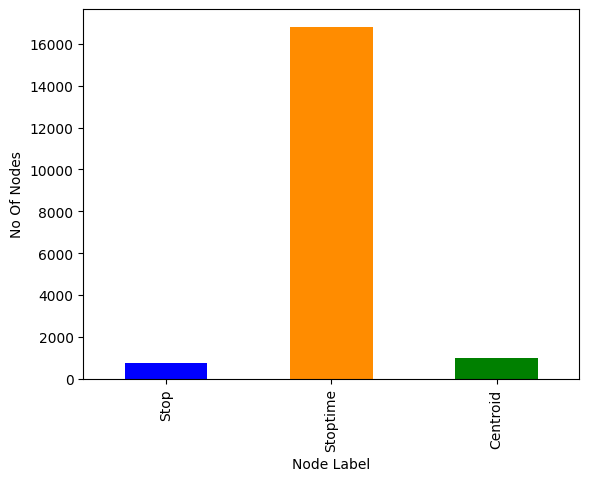

In [5]:
df_result_count=pd.Series({"Stop":result_stop,"Stoptime":result_stoptime,"Centroid":result_centroid})
df_result_count.plot(kind = "bar",color=["blue","darkorange","green"])
plt.xlabel("Node Label")
plt.ylabel("No Of Nodes")

### Appel graphs Cathia

#### Accessibilité en fonction du centroid

In [10]:
#Création d'un dataframe avec les résultats calculés
path_res = os.path.normpath('Results/res/res_1_min.txt')
res_1_min = pd.read_csv(path_res)
res_1_min.head()

,centroid,nb_destinations,trajets,trajets_ok,nb_station_DRT,DRT,DRT_ok,WALK_to_station_DRT,WALK,somme,somme_moyennée,accessibilite
0,0,16,14,0,0,0,0,0,14,145302.2196,9081.388725,0.000007
1,1,27,22,0,0,0,0,0,22,244999.1688,9074.043289,0.000004
2,9,102,1,0,0,0,0,0,1,688983.7740,6754.742882,0.000001
3,10,107,None,None,None,None,None,None,None,721314.7644,6741.259480,0.000001
4,11,109,92,4,0,0,0,0,92,738160.9740,6772.119028,0.000001


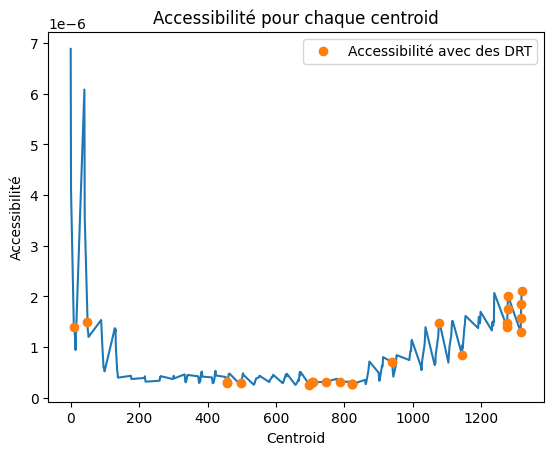

In [16]:
#Représentation de l'accessibilité pour chaque centroid 
plt.plot(res_1_min['centroid'], res_1_min['accessibilite'])
plt.xlabel('Centroid')
plt.ylabel('Accessibilité')
res_1_min_2 = res_1_min.loc[res_1_min['DRT'] != '0']
plt.plot(res_1_min_2['centroid'], res_1_min_2['accessibilite'], 'o', label="Accessibilité avec des DRT")
plt.legend()
plt.title('Accessibilité pour chaque centroid')
plt.show()

#### Représentation des centroids

In [4]:
# Exécuter le fichier "mon_script.py" en utilisant Python
path_data_centroids = os.path.normpath('.\Data\centroids.txt')

data_centroids = pd.read_csv(path_data_centroids)
data_centroids.head()


,centroid_id,centroid_lon,centroid_lat,distance,stop_id,departure_time,walking_time
0,0,-1.176972,45.842203,1647.850,2635,'08:30:00',1977.420
1,1,-1.176972,45.833058,2186.897,2635,'08:30:00',2624.276
2,2,-1.176972,45.823912,2986.020,2635,'08:30:00',3583.224
3,3,-1.176972,45.814766,2390.888,568,'08:30:00',2869.066
4,4,-1.176972,45.805620,1565.746,568,'08:30:00',1878.895


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


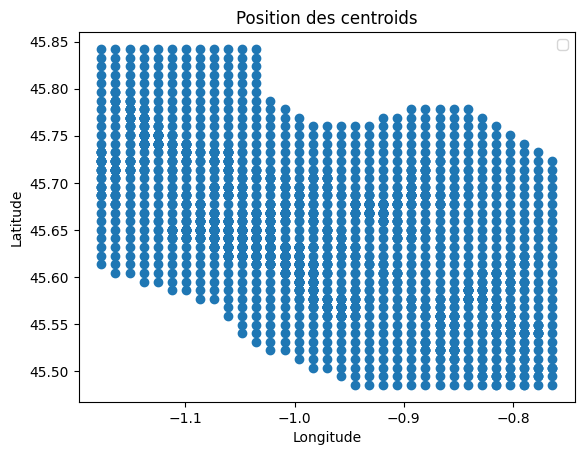

In [9]:
#On affiche la latitude en fonction de la longitude des centroids 
plt.plot(data_centroids['centroid_lon'], data_centroids['centroid_lat'], '+', label="position des centroids")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#data_centroids_DRT = res_1_min.loc[res_1_min['DRT'] != '0']
#plt.plot(data_centroids_DRT['centroid_lon'], data_centroids_DRT['centroid_lat'], 'o', label="Accessibilité avec des DRT")
plt.legend()
plt.title('Position des centroids')
plt.show()

In [46]:
path_stops = os.path.normpath('Data/stops.txt')
path_stops_drt = os.path.normpath('.\Stations\list_station_id.txt')

stops = pd.read_csv(path_stops)
stops_drt = pd.read_csv(path_stops_drt)

# Fusionner les deux DataFrames sur la colonne 'stop_id'
stops_filtered = pd.merge(stops, stops_drt[['station_list']], how='inner', left_on='stop_id', right_on='station_list')

#stops.head()
stops_filtered.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,station_list
0,384,ARC1A2,ARCES - Repos,ARRET DU RESEAU CARA BUS .,45.555863,-0.862525,384
1,411,ARV5A2,ARVERT - Ht Fouilloux,ARRET DU RESEAU CARA BUS .,45.748410,-1.133733,411
2,739,AUG2A1,ST-AUGUSTIN - Yeuse,ARRET DU RESEAU CARA BUS .,45.683450,-1.107148,739
3,2635,BOULYC,BOURCEFRANC - Lycée de la mer,ARRET DU RESEAU CARA BUS .,45.846776,-1.156793,2635
4,2568,BOUMA2,BOUTENAC-TOUVENT - Mairie,ARRET DU RESEAU CARA BUS .,45.505007,-0.757474,2568


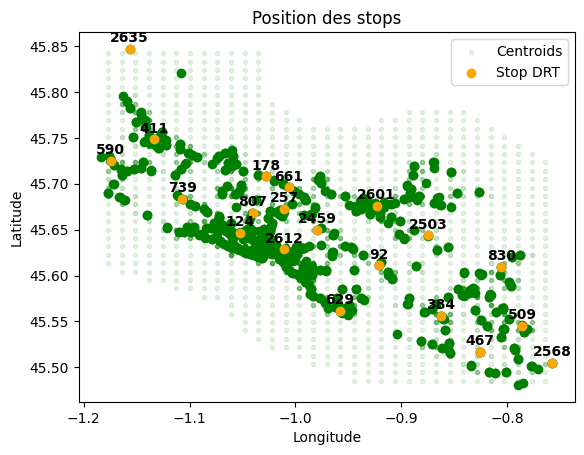

In [57]:
plt.scatter(data_centroids['centroid_lon'], data_centroids['centroid_lat'], c='green', alpha=0.1, marker='.', label="Centroids")
plt.scatter(stops['stop_lon'], stops['stop_lat'], c='green')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.scatter(stops_filtered['stop_lon'], stops_filtered['stop_lat'], c='orange', label="Stop DRT")

# Ajouter les étiquettes des points (stop_id) en gras et en rouge
for i in range(len(stops_filtered)):
    plt.annotate(stops_filtered['stop_id'][i], xy=(stops_filtered['stop_lon'][i], stops_filtered['stop_lat'][i]), textcoords='offset points', xytext=(0,5), ha='center', fontweight='bold')

plt.legend()
plt.title('Position des stops')
plt.show()

#### Reduction in inaccessibility

## LOUVAIN
Louvain est un algorithme de détection de communautés dans les graphes. Dans Neo4j, l'algorithme de Louvain est implémenté comme une procédure stockée (stored procedure) qui peut être exécutée dans la base de données graphique.

Lorsqu'il est exécuté, l'algorithme de Louvain identifie les communautés de nœuds (sommets) dans le graphe en maximisant la modularité du réseau. La modularité mesure la qualité de la division d'un graphe en communautés en comparant la densité des liens intra-communauté à la densité des liens inter-communautés.

En utilisant l'algorithme de Louvain dans Neo4j, il est possible d'identifier des groupes de nœuds (sommets) qui sont densément connectés entre eux, et qui sont plus faiblement connectés aux autres nœuds du graphe. Cela peut être utile pour des applications telles que l'analyse de réseaux sociaux, la détection de fraude ou la recommandation de produits.

Il est important de noter que l'algorithme de Louvain est basé sur des heuristiques et peut donc donner des résultats différents selon les paramètres d'entrée et les conditions initiales du graphe.

CALL gds.louvain.stream('graph_1', { relationshipWeightProperty: 'weight' })

YIELD nodeId, communityId, intermediateCommunityIds

RETURN gds.util.asNode(nodeId).name AS name, communityId

ORDER BY name ASC